/usr/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)



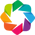

Holoviews Version: 1.8.1 1.8.1


In [1]:
if True:
    import sys
    hv_dev = '1.8.1'
    sys.path.insert(0, '/usr/lib/python3.5/site-packages/holoviews-'+hv_dev+'-py3.6.egg/')
else: hv_dev = ''

import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes(); sns.set_style('white')

import numpy as np
import pandas as pd
import holoviews as hv

hv.notebook_extension('bokeh', 'matplotlib')
from IPython.core.display import HTML

print( 'Holoviews Version: %s %s' % (hv_dev, hv.__version__) )

<div style="color:blue;text-align:left;font-size:25px;">Define a set of plots with options for Bokeh and for Matplotlib</div>
* generate a HoloMap of Matplotlib plots
* generate a HoloMap of Bokeh plots
* Generate SVG output
* Generate a Makefile and a Latex document including each of the plots

# Define the plots

In [4]:
SZ=8000; N=44; M=4
ddf  = pd.DataFrame( dict(err      = 5+np.random.normal(size=SZ),
                          Accept   = np.random.randint(2,size=SZ),
                          resultID = np.random.randint(N,size=SZ),
                          probID   = np.arange(SZ)
    ))
ddf.loc[ddf['resultID']==0,'Accept'] = 1


def extend_range( vals, p=.05 ):
    low = vals.min()
    hgh = vals.max()
    d   = (hgh-low)*p
    return (low-d,hgh+d)

def error_evolution_plots(df, N, backend='bokeh'):
    if backend is 'bokeh':
        print('set bokeh')
        spike_plot_opts = dict(xticks=5, yticks=5, width=600, height=300)
        scatter_style_0 = dict( size = 8, color='magenta')
        scatter_style_1 = dict( size = 8, color='blue')
    else:
        print('set matplotlib')
        spike_plot_opts = dict(xticks=5, yticks=5, fig_size=500, aspect=10)
        scatter_style_0 = dict( s = 100, color='magenta')
        scatter_style_1 = dict( s = 100, color='blue')

    # CAVEAT: workaround bug in HoloMaps
    h_bandaid = hv.Scatter( (-1000,0), kdims=['probID'], vdims=['err'] )

    d_plots = {}

    for f in np.arange(N):
        hv_df = hv.Table(df[df['resultID']==f], kdims=['probID', 'resultID'], vdims=['err','Accept'])
        if len(hv_df) is 0: continue
        pid_rng = extend_range(hv_df['probID'])
        err_rng = extend_range(hv_df['err'])

        h = hv.Spikes( hv_df, kdims=['probID'], vdims=['err']).opts(plot=spike_plot_opts)

        tmp1 = hv_df[hv_df['Accept']==1]
        if len(tmp1) > 0: h = h * hv.Scatter( tmp1, kdims=['probID'], vdims=['err'] ).opts(style=scatter_style_1 )
        else:             h = h * h_bandaid.opts(style=scatter_style_1)
        tmp0 = hv_df[hv_df['Accept']==0]
        if len(tmp0) > 0: h = h * hv.Scatter( tmp0, kdims=['probID'], vdims=['err'] ).opts(style=scatter_style_0 )
        else:             h = h * h_bandaid.opts(style=scatter_style_0)


        d_plots[f] = h.redim.range(probID=pid_rng, err=err_rng) \
                         .relabel('Error Evolution resultID = %d' % f)
    return d_plots

# Test the plots

set matplotlib


:Layout
   .HoloMap.Error_Evolution_resultID_equals_0 :HoloMap   [Default]
      :Overlay
         .Spikes.I   :Spikes   [probID]   (err)
         .Scatter.I  :Scatter   [probID]   (err)
         .Scatter.II :Scatter   [probID]   (err)
   .Overlay.Error_Evolution_resultID_equals_0 :Overlay
      .Spikes.I   :Spikes   [probID]   (err)
      .Scatter.I  :Scatter   [probID]   (err)
      .Scatter.II :Scatter   [probID]   (err)
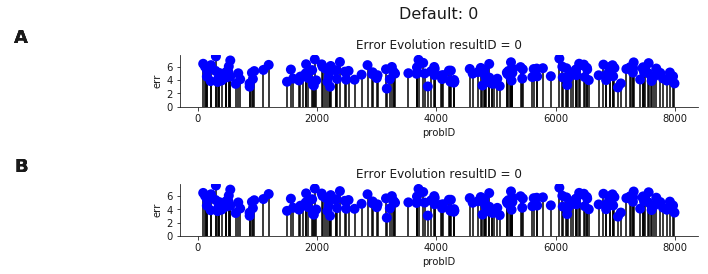
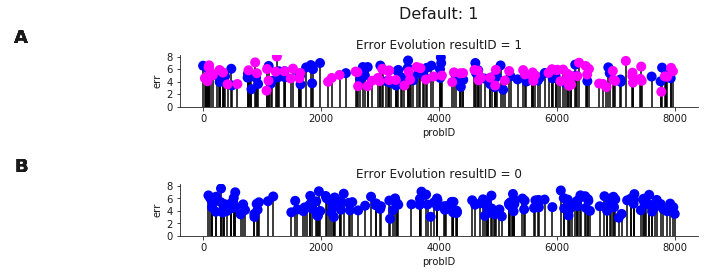
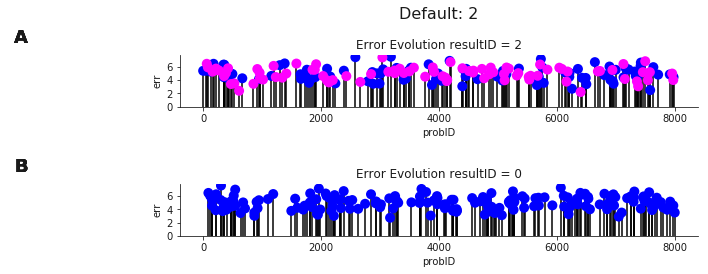
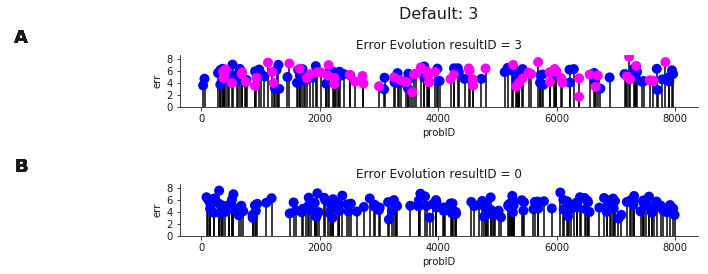
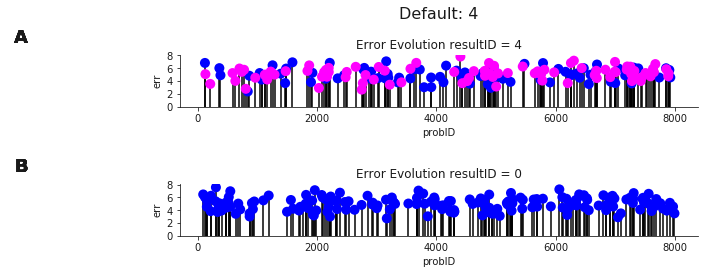
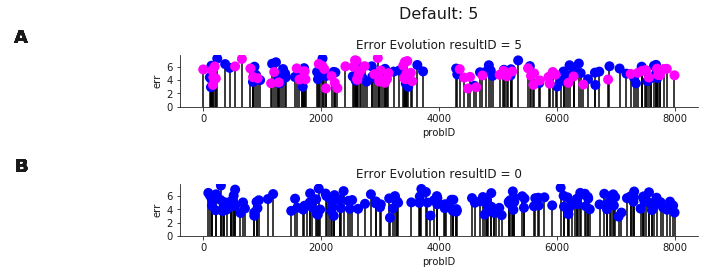
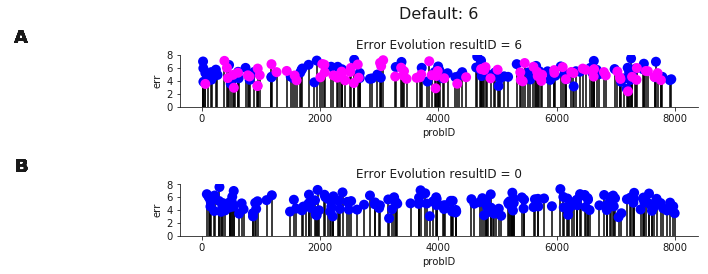
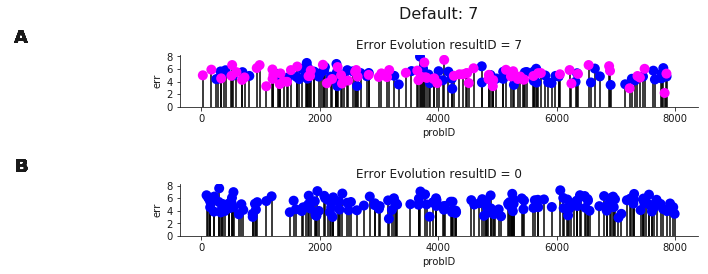
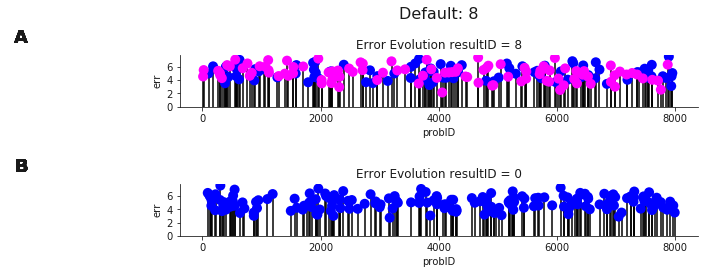
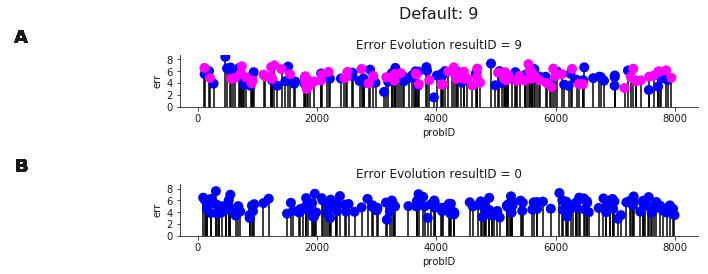
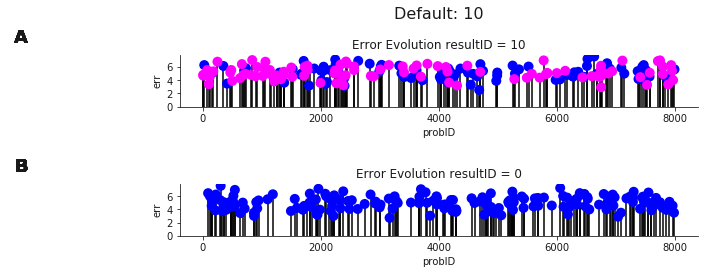
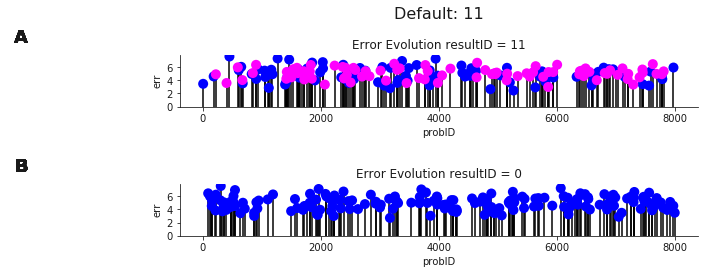
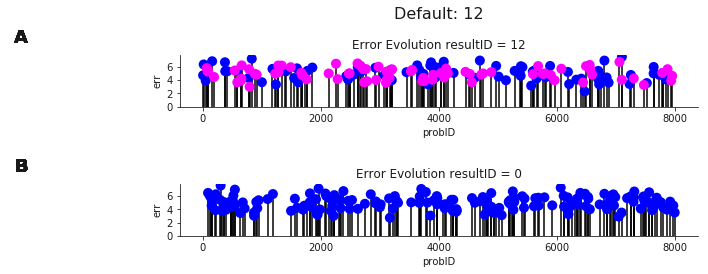
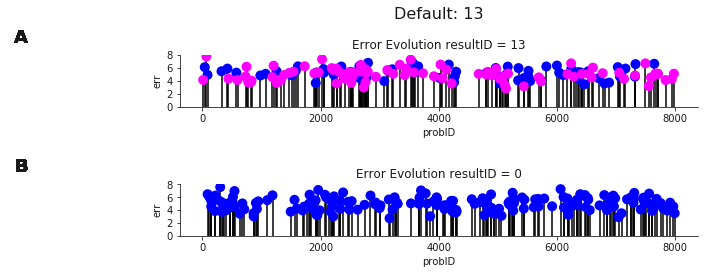
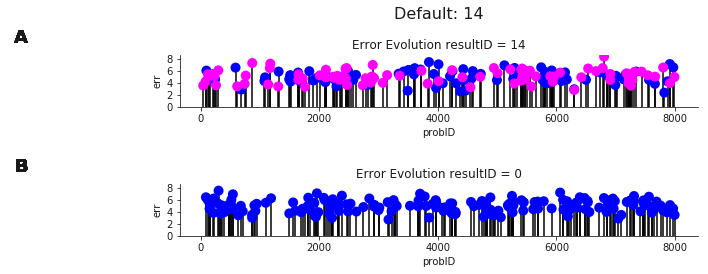
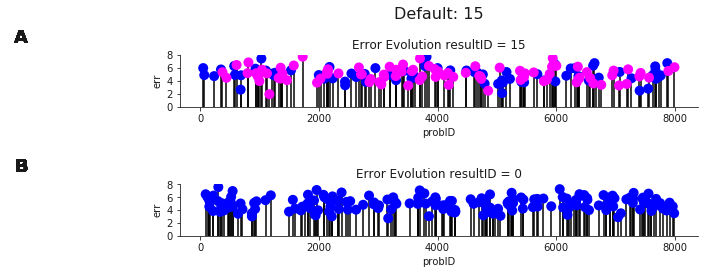
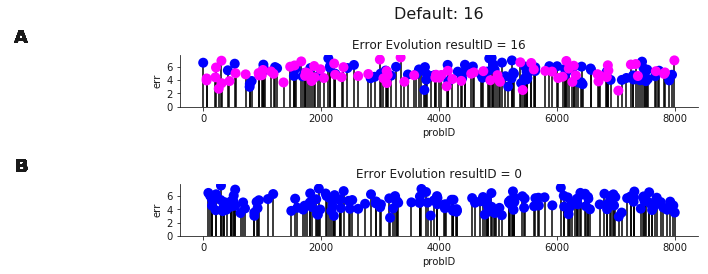
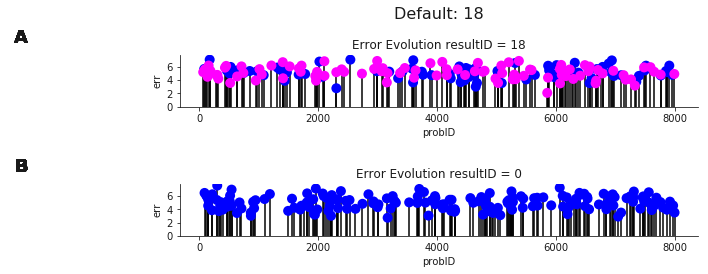
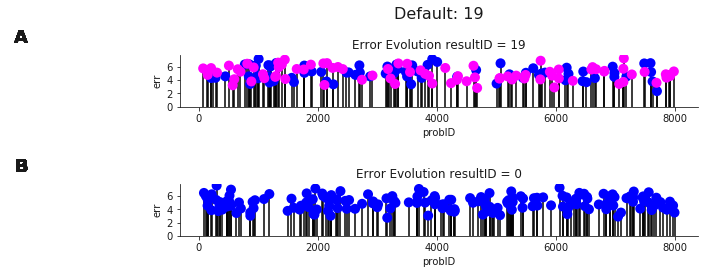
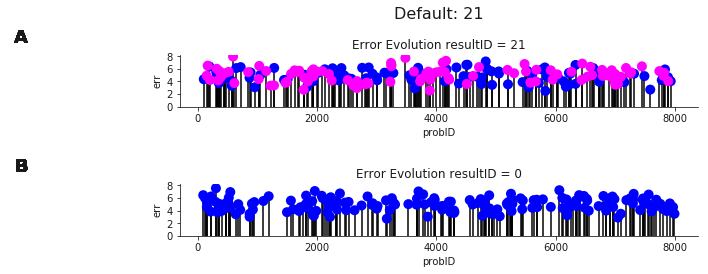
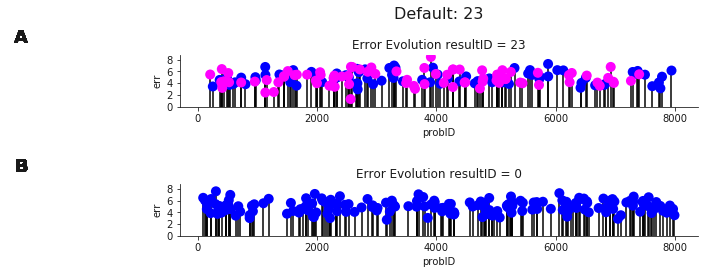
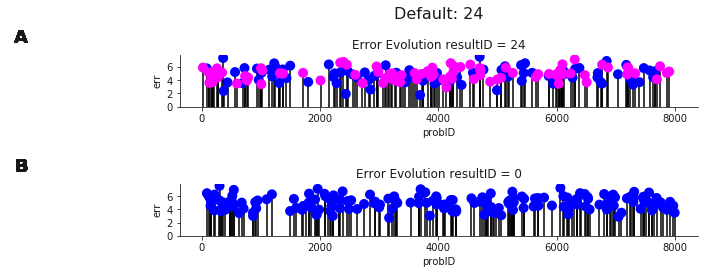
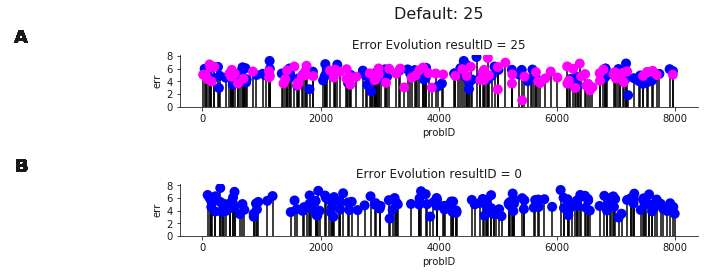
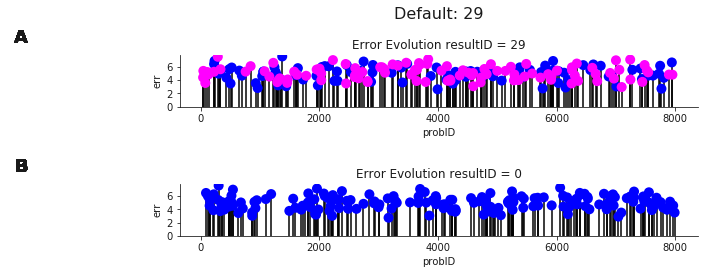
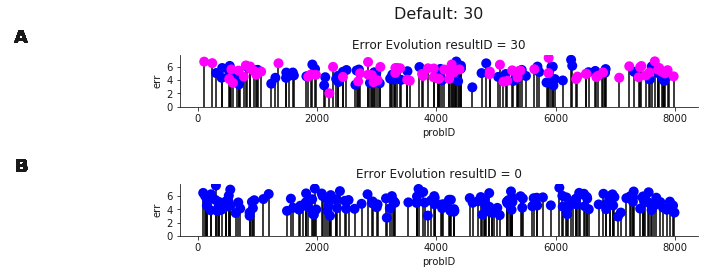
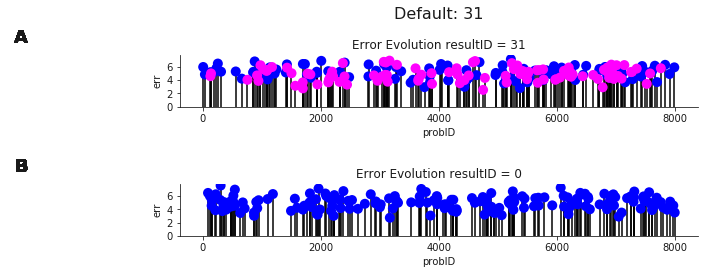
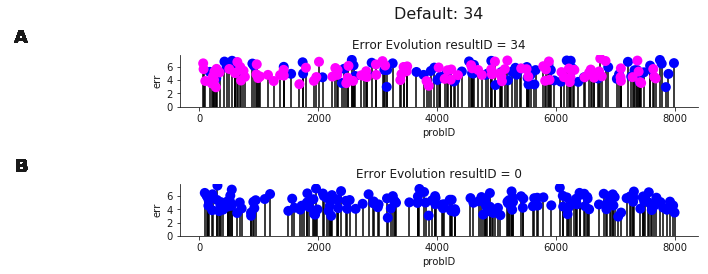
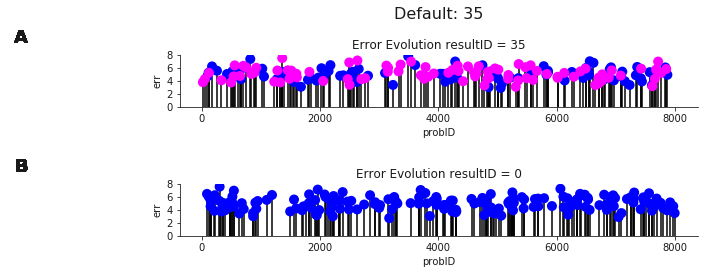
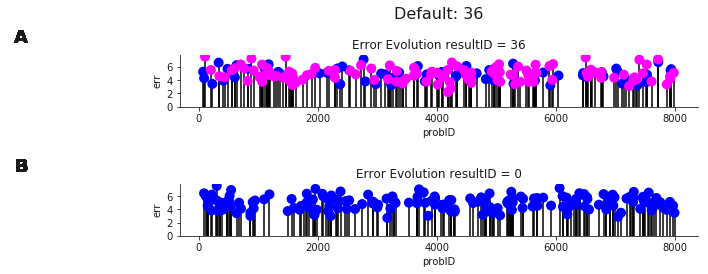
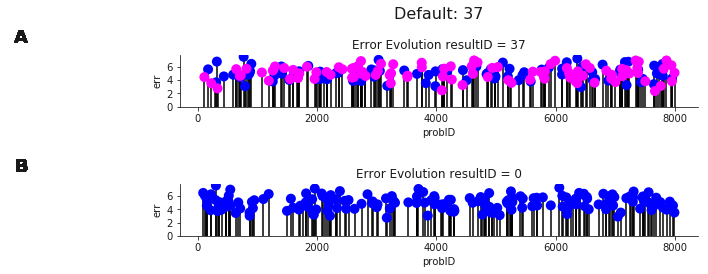
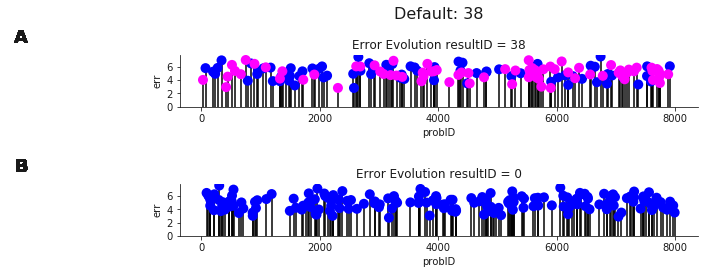
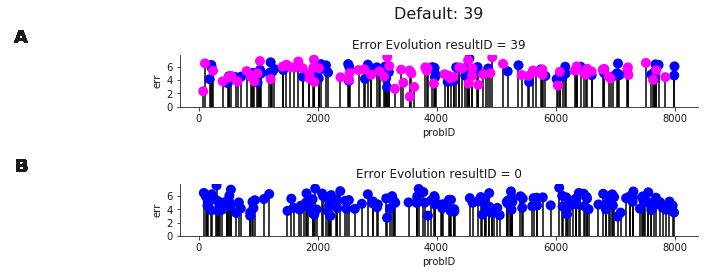
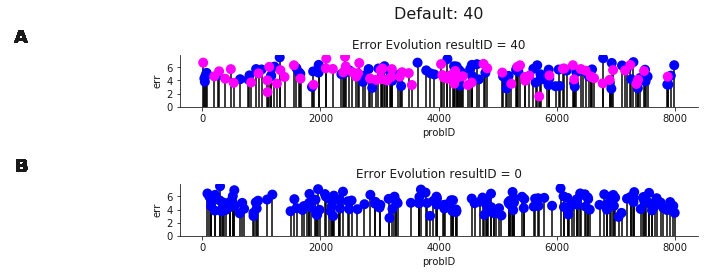
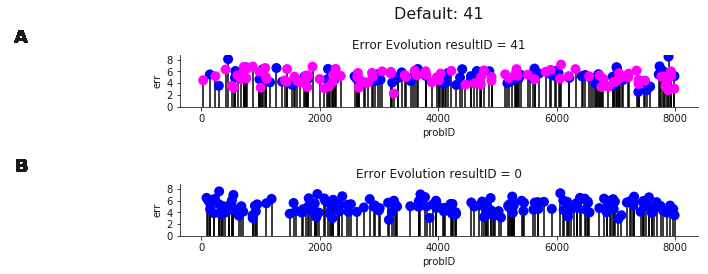
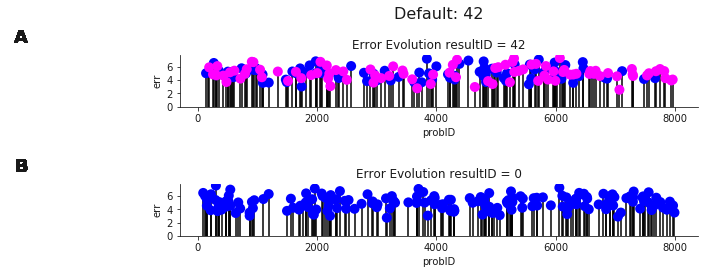
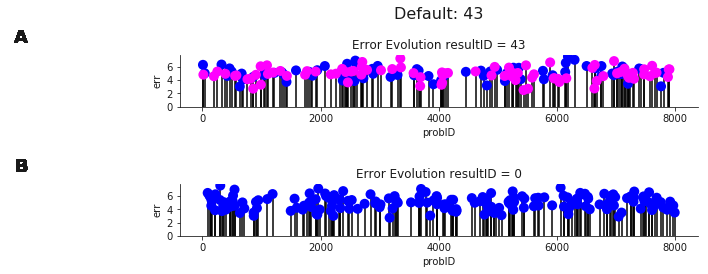

In [7]:
%%output backend='matplotlib'  size=200
%%opts Spikes Scatter {+framewise}

dd_plots = error_evolution_plots(ddf,N,'matplotlib')
(hv.HoloMap(dd_plots)+dd_plots[0]).cols(1)

In [14]:
%%output backend='bokeh'  size=150
%%opts Scatter Spikes {+framewise}
%%opts Scatter [tools=['hover']]
%%opts Overlay [height=200]

dd_plots = error_evolution_plots(ddf,N,'bokeh')
hmap=(hv.HoloMap(dd_plots)+dd_plots[0]).cols(1)
hmap

set bokeh


:Layout
   .HoloMap.Error_Evolution_resultID_equals_0 :HoloMap   [Default]
      :Overlay
         .Spikes.I   :Spikes   [probID]   (err)
         .Scatter.I  :Scatter   [probID]   (err)
         .Scatter.II :Scatter   [probID]   (err)
   .Overlay.Error_Evolution_resultID_equals_0 :Overlay
      .Spikes.I   :Spikes   [probID]   (err)
      .Scatter.I  :Scatter   [probID]   (err)
      .Scatter.II :Scatter   [probID]   (err)

# Render to SVG

In [38]:
%%output backend='matplotlib'  size=200
dd_plots = error_evolution_plots(ddf,N,'matplotlib')

fig_srcs_svg={}
renderer = hv.Store.renderers['matplotlib'].instance(fig='svg', holomap='gif')
for i in dd_plots.keys():
    fig_src = 'geo_%d'%i
    renderer.save(dd_plots[i],'/tmp/'+fig_src)
    fig_srcs_svg[i] = fig_src+'.svg'

set matplotlib


## Generate a makefile for a document including all the svg files

In [50]:
def gen_makefile(svg_srcs = fig_srcs_svg ):
    mk_header='''
MAIN := DOC

LATEXMK := latexmk

'''
    mk_footer = '''

FIGS_PGF = $(addprefix /tmp/,$(patsubst %.svg,FIG%.pdf,$(FIG_SRCS_SVG)))

$(MAIN).pdf: $(FIGS_PGF) $(MAIN).tex; $(LATEXMK) --pdf $(MAIN).tex

/tmp/FIG%.pdf: /tmp/%.svg; inkscape -D -z --file=$< --export-pdf=$@ --export-latex

    '''
    l_svg_srcs = [svg_srcs[i] for i in svg_srcs.keys() ]
    with open('/tmp/Makefile','w') as out:
        out.write(mk_header)
        out.write('FIG_SRCS_SVG =\\\n')
        out.write(" \\\n".join(l_svg_srcs))
        out.write("\n\n")
        out.write( mk_footer )

def gen_doc(svg_srcs = fig_srcs_svg ):
    doc_header=\
r'''\documentclass{article}
\usepackage{graphics}
\usepackage{color}
\usepackage[dvipsnames]{xcolor}
\usepackage{svg}
\usepackage[margin=10pt, font=small,labelfont=bf,format=default,indention=.5cm]{caption}
\usepackage{relsize}
\usepackage{fancyvrb}

\usepackage{verbatim}
\usepackage[pdftex,
            final=true,
            hyperfigures=true,
            bookmarks=true,
            bookmarksnumbered=true,
            bookmarksopen=false,
            pdftoolbar=true,
            colorlinks=true,
            urlcolor=webblue,
            linkcolor=webblue
            ]{hyperref}
\hypersetup{
pdfauthor = {},
pdftitle = {Geolocation Results Summary},
pdfsubject = {},
pdfkeywords = {},
pdfcreator = {LaTeX with hyperref package},
pdfproducer = {pdflatex}
}
% ---------------------------------------------------------------------------------------------------
\title{Summary}
\author{ea42gh}
%\makeindex

\begin{document}
\maketitle
'''
    doc_summary =\
r'''
\section*{Summary}
\section*{Error Evolution for each problemID}
'''
    doc_figure =\
r'''
\subsection*{Problem ID %d}
\begin{figure}[h]
    \centering
    \def\svgwidth{\columnwidth}
    \input{%s}
\end{figure}
\newpage
'''
    doc_footer =\
r'''
\end{document}
'''
    with open('/tmp/DOC.tex', 'w') as out:
        out.write( doc_header )
        for i in svg_srcs.keys():
            out.write( doc_figure %(i, "FIG"+svg_srcs[i].replace('.svg','.pdf_tex') ) )
        out.write( doc_footer )

gen_makefile()
gen_doc()
!cd /tmp; make

In [5]:
!ls

App_EulersMethod.ipynb	    HoloViews_Datashader.ipynb	__pycache__
App_Plot_With_Slider.ipynb  Images.ipynb		QuickTests.ipynb
assets			    _jlstevens.ipynb		randomwalk_app_V1.py
Bayes.ipynb		    lookat			randomwalk_app_V2.py
BokehApp.ipynb		    LOOKAT.txt			RandomWalk.ipynb
BokehTimothyDMorton.ipynb   Maps.ipynb			README.md
clouds.jpg		    MatrixImages.ipynb		sample-data
CurvesAndPaths.ipynb	    MyJs.js			set_colormap_alpha.py
dat.gui			    NEW				Untitled.ipynb
GenerateDocument.ipynb	    Polygons.ipynb
